In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, matthews_corrcoef
from sklearn.metrics import log_loss, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import joblib

In [2]:
df = pd.read_csv('num_df_train.csv')
X = df.drop('Cls', axis=1)
y = df['Cls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_test = pd.read_csv('num_df_test.csv')
X_test_external = df_test.drop('Cls', axis=1)
y_test_external= df_test['Cls']

In [3]:
# Define individual model classes and their parameter grids for grid search
models = {
    'RandomForest': (RandomForestClassifier(), {
        'n_estimators': [5, 20],
        'max_depth': [None, 5, 10]
    }),
    'CatBoost': (CatBoostClassifier(), {
        'iterations': [5, 20],
        'learning_rate': [0.05, 0.1]
    }),
    'LightGBM': (LGBMClassifier(), {
        'n_estimators': [5, 20],
        'max_depth': [5, 20],
        'learning_rate': [0.05, 0.1]
    }),
    'XGBoost': (XGBClassifier(), {
        'n_estimators': [5, 20],
        'max_depth': [5, 10],
        'learning_rate': [0.05, 0.1]
    }),
    'GradientBoosting': (GradientBoostingClassifier(), {
        'n_estimators': [5, 20],
        'max_depth': [5, 10],
        'learning_rate': [0.05, 0.1]
    })
}

# Perform grid search for each model
best_models = {}
for name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best {name} parameters: {grid_search.best_params_}")
    print(f"Best {name} ROC AUC score: {grid_search.best_score_}")

# Define the stacking ensemble with the best models
estimators = [(name, model) for name, model in best_models.items()]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Train the stacking ensemble on training dataset
stacking_model.fit(X_train, y_train)

# Define the filename for saving the model
model_filename = "stacking_ensemble_model1.pkl"

# Save the stacking ensemble model to a .pkl file
joblib.dump(stacking_model, model_filename)

print(f"Stacking ensemble model saved as '{model_filename}'")



Best RandomForest parameters: {'max_depth': None, 'n_estimators': 20}
Best RandomForest ROC AUC score: 0.8701519079260441
0:	learn: 0.6833833	total: 369ms	remaining: 1.48s
1:	learn: 0.6733789	total: 570ms	remaining: 855ms
2:	learn: 0.6645712	total: 754ms	remaining: 503ms
3:	learn: 0.6553312	total: 924ms	remaining: 231ms
4:	learn: 0.6464896	total: 1.08s	remaining: 0us
0:	learn: 0.6832630	total: 218ms	remaining: 873ms
1:	learn: 0.6717534	total: 394ms	remaining: 591ms
2:	learn: 0.6636778	total: 571ms	remaining: 381ms
3:	learn: 0.6559599	total: 752ms	remaining: 188ms
4:	learn: 0.6471268	total: 938ms	remaining: 0us
0:	learn: 0.6857017	total: 206ms	remaining: 826ms
1:	learn: 0.6740592	total: 402ms	remaining: 602ms
2:	learn: 0.6652960	total: 582ms	remaining: 388ms
3:	learn: 0.6548289	total: 764ms	remaining: 191ms
4:	learn: 0.6459701	total: 962ms	remaining: 0us
0:	learn: 0.6831351	total: 185ms	remaining: 742ms
1:	learn: 0.6722638	total: 352ms	remaining: 528ms
2:	learn: 0.6617923	total: 516ms	r

In [4]:
# Evaluate the final stacking ensemble on the external test dataset
y_pred_stacking = stacking_model.predict_proba(X_test_external)[:, 1]
auc_stacking = roc_auc_score(y_test_external, y_pred_stacking)
print(f"Final Stacking Ensemble ROC AUC on Test Data: {auc_stacking}")



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Final Stacking Ensemble ROC AUC on Test Data: 0.9377230935640887


still working on this

In [5]:
accuracy = accuracy_score(y_test_external, y_pred_stacking) #giving error ValueError: Classification metrics can't handle a mix of binary and continuous targets
print("Accuracy:", accuracy)
print('Classification Report:')
print(classification_report(y_test_external, y_pred_stacking))
print('Confusion Matrix:')
cm = confusion_matrix(y_test_external, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


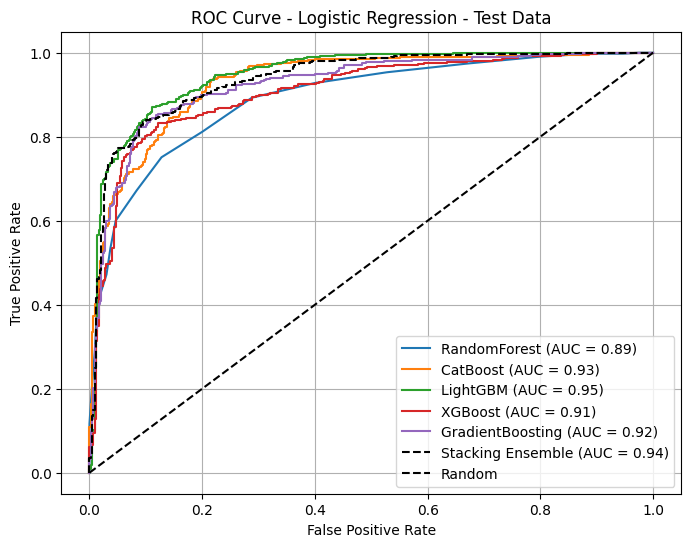

In [6]:
# Plot ROC curves for all models and the stacking ensemble on the test dataset
plt.figure(figsize=(8, 6))

# Plot ROC curves for individual models using the test dataset
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test_external)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_external, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test_external, y_pred_proba):.2f})')

# Plot ROC curve for the stacking ensemble on the test dataset
fpr_stacking, tpr_stacking, _ = roc_curve(y_test_external, y_pred_stacking)
plt.plot(fpr_stacking, tpr_stacking, linestyle='--', color='black', label=f'Stacking Ensemble (AUC = {auc_stacking:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Set plot properties
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - Test Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()